# XGBoost with Scikit-Learn Pipeline & GridSearchCV

XGBoost provides a wrapper interface to use the model as if it another model from Scikit-Learn [(more info in the documentation)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn). 

In this notebook we show an example on how we can use XGBoost with Pipelines and GridSearchCV like any other Scikit-Learn model.

In [1]:
import pathlib
import pickle
import pandas as pd
import xgboost as xgb

from matplotlib import pyplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Dataset

For this example we'll use a simple dataset: [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data).

In [2]:
data_path: pathlib.Path = pathlib.Path("../data")
breast_cancer_data_path: pathlib.Path = data_path / "breast-cancer-wisconsin-data.csv"
df = pd.read_csv(breast_cancer_data_path)
X = df.drop(columns=["id", "Unnamed: 32", "diagnosis"])
y = df["diagnosis"].map({'B': 0, 'M': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

## Define the Pipeline and GridSearch

The `XGBClassifier` class implements the Scikit-Learn interface for using XGBoost for classification. That means that it has the familiar `fit` method as well as `predict`, `score` and so on.

The preprocessing methods to use in the pipeline and the parameters to optimize are just for the sake of the example.

In [3]:
model = xgb.XGBClassifier()

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('pca', PCA()), 
    ('model', model)
])

param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

In [4]:
%%time

grid.fit(X_train, y_train)

CPU times: user 7.42 s, sys: 485 ms, total: 7.9 s
Wall time: 1min 35s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      gamma=None, gpu_id=None,
                                             

## CV results

Here are the results of the model that gave the best mean score in the k-fold cross-validation

In [5]:
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

grid.best_params_, mean_score, std_score

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__max_depth': 2, 'model__n_estimators': 500, 'pca__n_components': 15}
Mean CV score:  0.988988
Standard deviation of CV score:  0.009521


## Plot Performance

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.993


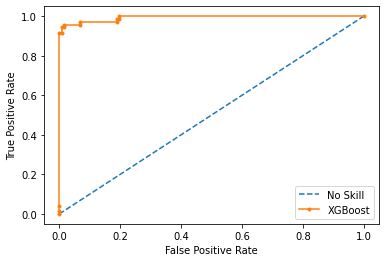

In [6]:
lr_probs = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# persist the model

In [7]:
pickle_path = pathlib.Path("../model_artifacts/")
with open(pickle_path / "xgboost-classifier.pkl", "wb") as oh:
    pickle.dump(grid, oh)